# Value at Risk (VaR) and Expected Shortfall (ES) Calculation

### Background on VaR and ES
If you are new to financial risks, you may click the below links to understand more about them; If you are already familiar, feel free to skip to the code directly!

#### VaR
https://www.risk.net/definition/value-at-risk-var

#### ES
https://www.risk.net/definition/expected-shortfall

#### Difference between VaR and ES
https://www.risk.net/risk-magazine/technical-paper/1506669/var-versus-expected-shortfall

### Setup

Note: yfinance api is used here since it is widely used and free, and most importantly with datetime package we can roll the program daily and calculate the risk measure automatically

In [1]:
# import necessary packages

# import statistical packages
import pandas as pd
import numpy as np
from scipy.stats import norm
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import api datasource
import yfinance as yf

# import date calculation package
from datetime import datetime, timedelta

# import visualisation packages
import matplotlib.pyplot as plt
import matplotlib as mpl

# warning exception handling
pd.options.mode.chained_assignment = None

# some customisation could be used if needed
# plt.style.use('seaborn-v0_8-dark-palette')
# mpl.rcParams['axes.prop_cycle'] = cycler(color=['#8DC2DF', '#003A79', '#ECBD00', '#006C24', '#EC6400'])

### Input
Here we can input the any ticker as long as the ticker is available on Yahoo Finance

Example: We input 'VOO' for Vanguard S&P 500 ETF

Alpha is adjustable here and normally we input 0.05, 0.25 and 0.01 for 95%, 97.5% and 99% confidence level respectively

In [2]:
# Define the ticker symbol for the stock you want to analyze
symbol = 'VOO'

# Define the parameters for VaR calculation
alpha = 0.05
confidence_level = 1 - alpha

VaR and ES are usually taken at 1-year timeframe for calculation, so the days equal to 365

In [3]:
# Download historical data using yfinance
start_date = datetime.today() - timedelta(days=365)
end_date = datetime.today()
data = yf.download(symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


Calculate daily returns for further processing

In [4]:
# Calculate daily returns
data['Returns'] = data['Adj Close'].pct_change().dropna()
data = data.tail(-1)

# Calculate daily log returns
data['LogReturns'] = np.log(data['Adj Close']).diff().dropna()
data = data.tail(-1)

# Calculate mean of daily returns and standard deviation
returns_mean = data['LogReturns'].mean()
returns_std = data['LogReturns'].std()

### Model parameters determination
We look at the autocorrelation and partial auto-correlation of the returns to determine the p and q parameters in the GARCH model

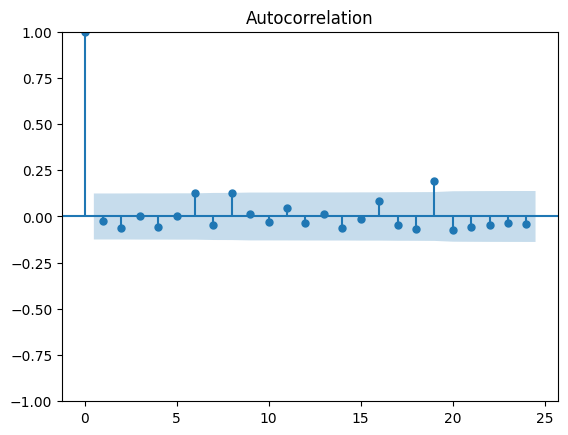

In [5]:
# De-trend the data
squared_returns = data['LogReturns']**2

# Ploting Autocorrelation
plot_acf(squared_returns)
plt.show()

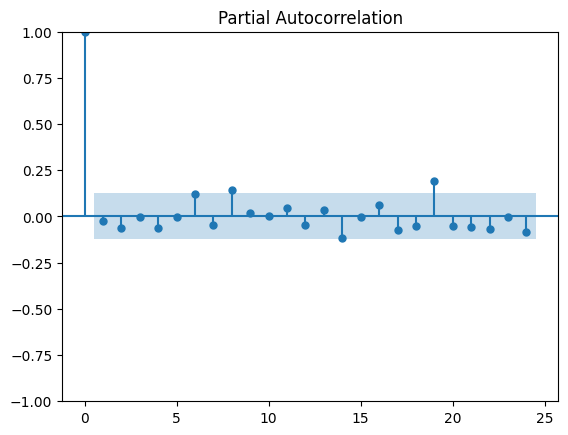

In [6]:
# Ploting Partial Autocorrelation
plot_pacf(squared_returns)
plt.show()

Since there is no significant lag in both ACF and PACF graphs, we can proceed with GARCH(1,1) Model

Generalised AutoRegressive Conditional Heteroskedasticity (GARCH) model used here is a popular model to forecast the volatility, and we used the modelled returns and volatilities to estimate the VaR

In [7]:
# Calculate filtered returns and VaR using GARCH model
model = arch_model(data['LogReturns'], vol='Garch', p=1, q=1, rescale=False)
result = model.fit(update_freq=5)
data['FilteredReturns'] = -data['LogReturns'] / result.conditional_volatility / 100
data['GARCHVaR'] = result.conditional_volatility * data['FilteredReturns'].quantile(alpha) * 100

Optimization terminated successfully    (Exit mode 0)
            Current function value: -869.4247462244438
            Iterations: 2
            Function evaluations: 25
            Gradient evaluations: 2


Here we calculated the ES and a simplified stressed ES for demonstration purpose

In [8]:
# Calculate ES using historical simulation
sorted_returns = data['LogReturns'].sort_values(ascending=True)
index = int(alpha * len(sorted_returns))
data['ES'] = sorted_returns[:index].mean()

# Calculate stressed ES
stress_factor = 1.5
risk_weight = 2.0
data['StressedES'] = data['ES'] * stress_factor

And finally, we plot the histograms of modelled returns, normal distrbution line and risk measures

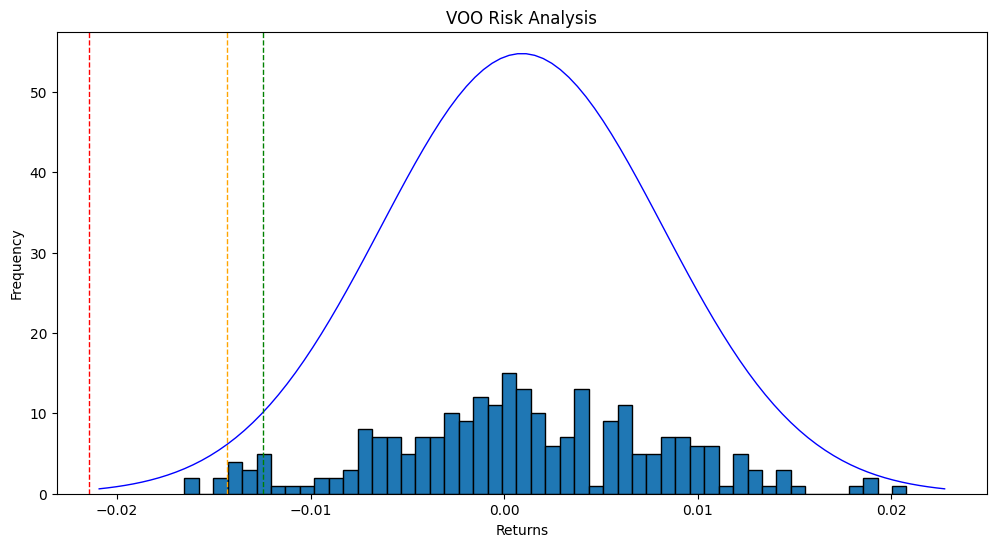

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate returns histogram
returns_hist = plt.hist(data['LogReturns'], bins=50, edgecolor='black', linewidth=1)

# Plot normal distribution line
x = np.linspace(returns_mean - 3 * returns_std, returns_mean + 3 * returns_std, 100)
y = norm.pdf(x, returns_mean, returns_std)
ax.plot(x, y, color='blue', linewidth=1)

# Plot vertical lines for risk measures
plt.axvline(data['GARCHVaR'].iloc[-1], color='green', linestyle='--', linewidth=1)
plt.axvline(data['ES'].iloc[-1], color='orange', linestyle='--', linewidth=1)
plt.axvline(data['StressedES'].iloc[-1], color='red', linestyle='--', linewidth=1)

# Customize the plot
plt.title(f'{symbol} Risk Analysis')
plt.xlabel('Returns')
plt.ylabel('Frequency')

plt.show()

#### Interpertation of the visualisation

Green line = VaR
Yellow line = ES
Red line = Simplified Stressed ES

The visualisation will show the approximate risks from each risk measure. For the precise VaR amount, the below summary will conclude the risk amount in dollar terms in VaR and ES

In [10]:
VaR_amount = data['GARCHVaR'][-1] * data['Adj Close'][-1]

print(f'There is {confidence_level*100}% confidence, that over the coming 365 days the {symbol} will not lose more than {-VaR_amount}')

There is 95.0% confidence, that over the coming 365 days the VOO will not lose more than 5.822486807622875


In [11]:
ES_amount = data['ES'][-1] * data['Adj Close'][-1]

print(f'There is {confidence_level*100}% confidence, that over the coming 365 days the {symbol} will not lose more than {-ES_amount}')

There is 95.0% confidence, that over the coming 365 days the VOO will not lose more than 6.677887496640518


Let's do coverage test to test if the VaR is accurate or not:

In [12]:
# Calculate the number of exceedances
exceedances = np.sum((data['LogReturns'] < 0) & (data['LogReturns'] < data['GARCHVaR']))

# Calculate the number of exceedances expected at the specified alpha level
expected_exceedances = len(data) * alpha

# Calculate the test statistic
test_statistic = (exceedances - expected_exceedances) / np.sqrt(expected_exceedances * (1 - alpha))

# Calculate the p-value
p_value = 1 - norm.cdf(test_statistic)

# Perform the coverage test
if p_value >= 0.05:
    print("Coverage test passed: VaR is accurate at the specified alpha level.")
else:
    print("Coverage test failed: VaR is not accurate at the specified alpha level.")

Coverage test passed: VaR is accurate at the specified alpha level.


Let's also do distribution test to test if the returns are normally distributed

In [13]:
# Calculate the correlation between returns and filtered returns
correlation = data['LogReturns'].corr(data['FilteredReturns'])

# Perform Filiben's correlation test for normality
if abs(correlation) < 0.1:
    print("Distribution test passed: Returns are approximately normally distributed.")
else:
    print("Distribution test failed: Returns are not normally distributed.")

Distribution test failed: Returns are not normally distributed.
